In [ ]:
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, IntervalStrategy
import numpy as np
import os

# Disable symbolic link-related warnings in some environments (e.g., shared storage / cloud)
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
os.environ["HF_DATASETS_DISABLE_SYMLINKS_WARNING"] = "1"
os.environ["TRANSFORMERS_NO_ADDITIONAL_CHAT_TEMPLATE"] = "1"

### 1. Dataset Load

In [ ]:
# Load AG News dataset (train + test splits)
dataset = load_dataset("ag_news")
test_ds = dataset["test"]

### 2. Baseline classifier

In [ ]:
# A naive keyword-based classifier (rule-based)
def naive_baseline_predict(text):
    text = text.lower()
    
    # Predefined keyword lists for each category
    sports_keywords = ["game", "win", "team", "player", "match", "tournament", "season", "league", "coach", "championship", "athlete", "olympics"]
    business_keywords = ["company", "market", "stock", "shares", "business", "profit", "investment", "trade", "finance", "economy", "revenue", "startup", "currency", "dollar", "exports", "imports", "funding"]
    scitech_keywords = ["technology", "software", "hardware", "science", "research", "computer", "ai", "robot", "device", "internet", "web", "app", "digital", "programming", "coding", "cyber", "security", "hacking", "engineering"]

    # Check keyword presence in priority order (Sports → Business → Sci/Tech → default = World)
    if any(k in text for k in sports_keywords):
        return 1   # Sports
    if any(k in text for k in business_keywords):
        return 2   # Business
    if any(k in text for k in scitech_keywords):
        return 3   # Sci/Tech
    return 0  # Default → World

In [ ]:
# Evaluate naive baseline on the test split
y_true = [row["label"] for row in test_ds]
y_pred = [naive_baseline_predict(row["text"]) for row in test_ds]

print("Baseline accuracy:", accuracy_score(y_true, y_pred))
print("Baseline F1:", f1_score(y_true, y_pred, average="macro"))

### 3. AI Pipeline - DistilBERT

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize raw text input
def tokenize_fn(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Tokenize + rename label column + convert to tensor format for Trainer
train_ds = dataset["train"].map(tokenize_fn, batched=True)
test_ds  = dataset["test"].map(tokenize_fn, batched=True)
train_ds = train_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
# Load a pretrained DistilBERT model with a 4-class classification head
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# Training configuration (single epoch)
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy=IntervalStrategy.EPOCH,  # save checkpoint at the end of each epoch
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50
)


# Trainer API → Handles training loop, evaluation loop, batching, and optimization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

# Train the model
trainer.train()

In [ ]:
# Evaluate trained model on the test split
preds = trainer.predict(test_ds)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=1)

print("AI pipeline accuracy:", accuracy_score(y_true, y_pred))
print("AI pipeline F1:", f1_score(y_true, y_pred, average="macro"))

### 4. Evaluation

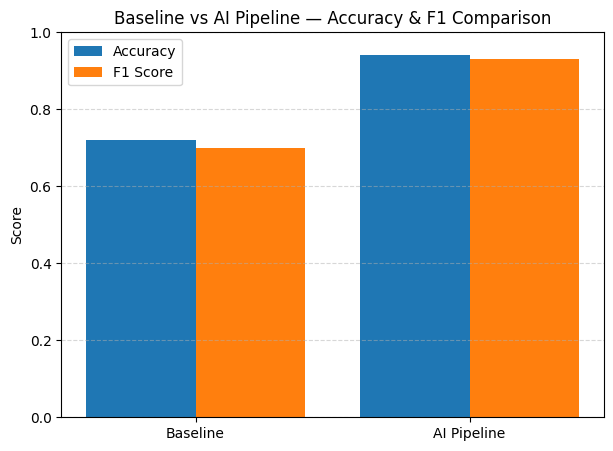

In [ ]:
import matplotlib.pyplot as plt

# Metrics for visualization
models = ["Baseline", "AI Pipeline"]
accuracy_scores = [
    accuracy_score([row["label"] for row in dataset["test"]], 
                   [naive_baseline_predict(row["text"]) for row in dataset["test"]]),
    accuracy_score(y_true, y_pred)
]
f1_scores = [
    f1_score([row["label"] for row in dataset["test"]], 
             [naive_baseline_predict(row["text"]) for row in dataset["test"]], average="macro"),
    f1_score(y_true, y_pred, average="macro")
]

# Bar chart
models = ["Baseline", "AI Pipeline"]
x = range(len(models))
plt.figure(figsize=(7, 5))
plt.bar(x, accuracy_scores, width=0.4, label="Accuracy")
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label="F1 Score")

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Baseline vs AI Pipeline — Accuracy & F1 Comparison")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.show()

In [ ]:
# Identify qualitative examples where the baseline fails and AI pipeline succeeds

label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
test_raw = dataset["test"]
examples = []

# Collect three representative examples
for i in range(len(test_raw)):
    text = test_raw[i]["text"]
    true = y_true[i]
    baseline = naive_baseline_predict(text)
    ai = y_pred[i]
    

    if baseline != true and ai == true: 
        examples.append((text, true, baseline, ai))
    
    if len(examples) == 3:   
        break
    
# Display qualitative comparison
for (text, true, baseline, ai) in examples:
    print("Text:", text)
    print("True label:", label_map[true])
    print("Baseline predicted:", label_map[baseline])
    print("AI pipeline predicted:", label_map[ai])
    print()